In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse.linalg as spLA
import numpy.linalg as LA

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

In [30]:
N_tot = 1000
N_men = N_tot // 2
N_women = N_tot // 2
num_groups_men = 4
num_groups_women = 4

# Generate ranks
s_men = np.random.uniform(low=1, high=10, size=N_men)
s_women = np.random.uniform(low=1, high=10, size=N_women)

# Generate groups
g_men = np.random.randint(0, num_groups_men, size=N_men)
G_m = np.zeros((N_men, num_groups_men))
for man_id, group_id in enumerate(g_men):
    G_m[man_id, group_id] = 1
    
# Generate group preferences
group_pref = np.abs(np.random.normal(0, 1))
group_disc = np.abs(np.random.normal(0, 1))

# Theta[i, j] - Preference of woman in group i towards a man in group j
Theta = np.zeros((num_groups_women, num_groups_men))
for i in range(num_groups_women):
    Theta[num_groups_women-1, i] = -group_disc
    Theta[i, i] = group_pref # overwrite for last group

In [31]:
Theta

array([[ 0.35877167,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.35877167,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.35877167,  0.        ],
       [-0.40755023, -0.40755023, -0.40755023,  0.35877167]])

In [32]:
def generate_network(N, s, G, theta, beta):
    
    ranks = s + np.matmul(G, theta)
    
    Z = 0
    scaled_energy = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            energy_ij = 0.5 * np.power(ranks[i] - ranks[j] - 1, 2)
            scaled_energy[i, j] =  np.exp(-beta * energy_ij)
            Z += scaled_energy[i, j]
    c = 10 * N / Z
    
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            A[i, j] += np.random.poisson(c * scaled_energy[i, j])
            
    return A

In [33]:
beta = 0.5

A_t = []
A = np.zeros((N_men, N_men))

for i in range(num_groups_women):
    A_i = generate_network(N_men, s_men, G_m, Theta[i], beta)
    A_t.append(A_i)
    A += A_i

In [34]:
s_est = sr.SpringRank(A)

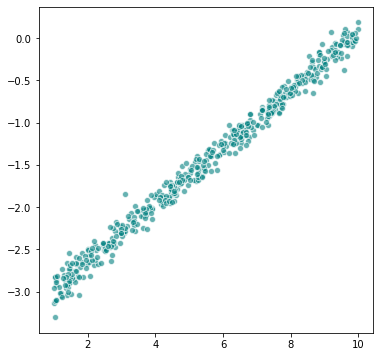

In [35]:
plt.figure(figsize=(6, 6))

plt.scatter(s_men, s_est, color='teal', edgecolor='white', alpha=0.6)

plt.show()

### Extract hierarchy with groups

In [36]:
l_a = 5e-2
l_b = [5e-1, 2e-2, 1e-1, 3e-2]

# Construct full Laplacian
N = A.shape[0]
k_in = np.sum(A, 0)
k_out = np.sum(A, 1)
L = np.diag(k_out + k_in) - (A + A.T)

# Construct group Laplacians
L_t = []
k_t_in = []
k_t_out = []
for A_r in A_t:
    N_r = A_r.shape[0]
    k_r_in = np.sum(A_r, 0)
    k_r_out = np.sum(A_r, 1)
    L_r = np.diag(k_r_out + k_r_in) - (A_r + A_r.T)
    
    L_t.append(L_r)
    k_t_in.append(k_r_in)
    k_t_out.append(k_r_out)

# Row 1
LHS = L #+ l_a*np.eye(N_men)
for L_r in L_t:
    LHS = np.concatenate((LHS, np.matmul(L_r, G_m)), axis=1)
RHS = k_out - k_in

filler_matrix = np.zeros((num_groups_men, num_groups_men))

# Row n
for i, L_r in enumerate(L_t):
    compressed = np.matmul(G_m.T, L_r)
    row_n = compressed
    block = np.matmul(compressed, G_m) #+ l_b[i]*np.eye(num_groups)
    for j in range(num_groups_women):
        if i == j:
            row_n = np.concatenate((row_n, block), axis=1)
        else:
            row_n = np.concatenate((row_n, filler_matrix), axis=1)
    LHS = np.concatenate((LHS, row_n), axis=0)
    RHS = np.concatenate((RHS, np.matmul(G_m.T, k_t_out[i] - k_t_in[i])), axis=0)

In [37]:
output = spLA.bicgstab(LHS, RHS)
x = output[0]
print(x.shape)

(516,)


In [38]:
s_est = x[:N_men]
Theta_est = np.zeros((num_groups_women, num_groups_men))
for r in range(num_groups_women):
    start_idx = N_men + (r*num_groups_men)
    end_idx = N_men + (r*num_groups_men) + num_groups_men
    theta_r = x[start_idx:end_idx]
    for s, val in enumerate(theta_r):
        Theta_est[r, s] = val

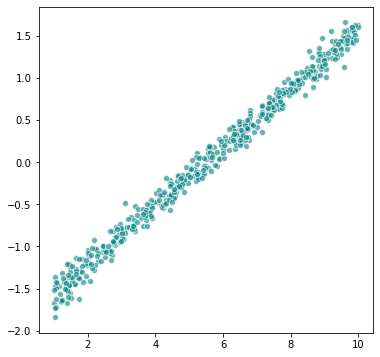

In [48]:
plt.figure(figsize=(6, 6))

plt.scatter(s_men, s_est, color='teal', edgecolor='white', alpha=0.6)

plt.show()

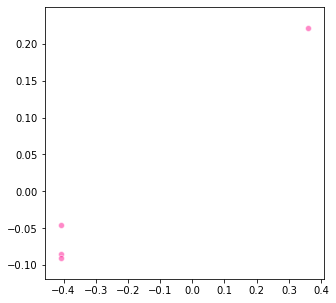

In [47]:
plt.figure(figsize=(5, 5))

group_id = 3
group_shift = 0

plt.scatter(Theta[group_id].flatten(),
            Theta_est[group_id].flatten() + group_shift,
            color="deeppink", edgecolor="white", alpha=0.5)

plt.show()